In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from MODULES.utilities import load_obj
import torch
import numpy as np
from scipy.sparse import coo_matrix
import networkx as nx
import community as community_louvain
import skimage.color
import time
import functools 


#!pip install python-louvain

### Load the multichannel segmentation mask

In [3]:
mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/merfish_june23_v1/seg_mask_multichannels.pkl"


integer_seg_mask, raw_img = load_obj(mask_file)
print(integer_seg_mask.shape, raw_img.shape)

torch.Size([16, 500, 500]) torch.Size([1, 500, 500])


### Segmentation Mask produced with Sliding window has boundary effect

In [4]:
n_cells = torch.max(integer_seg_mask.flatten(start_dim=1),dim=-1)[0]
print(n_cells)

tensor([430, 424, 403, 392, 423, 417, 397, 393, 426, 414, 394, 394, 405, 403,
        392, 380])


Text(0.5, 1.0, 'raw image')

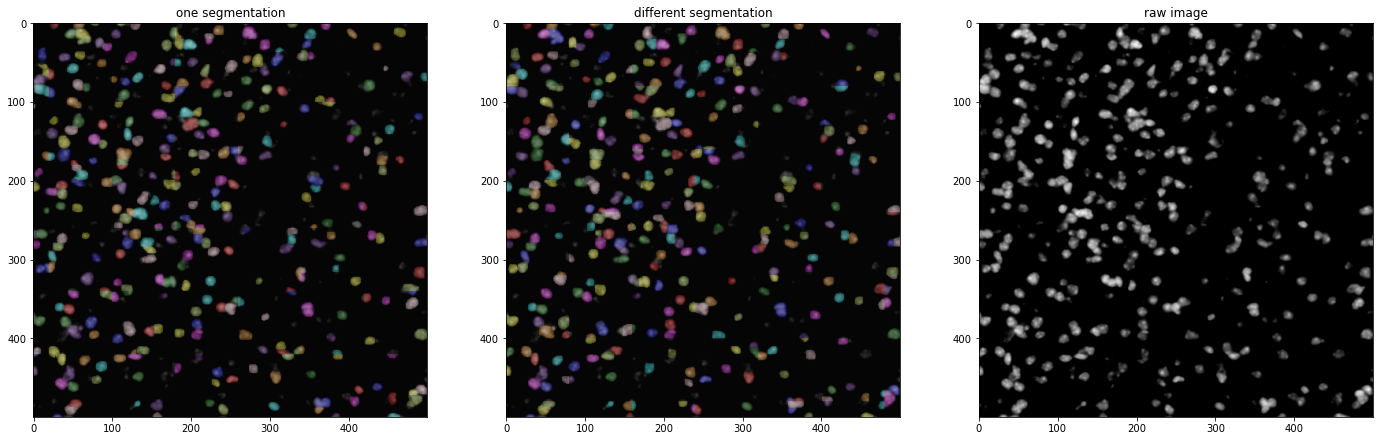

In [5]:
label0 = (integer_seg_mask[0] % 255).cpu().numpy()
label1 = (integer_seg_mask[-1] % 255).cpu().numpy()
img = raw_img[0].cpu().numpy()


figure, axes = plt.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(skimage.color.label2rgb(label0, img, alpha=0.25, bg_label=0))
axes[1].imshow(skimage.color.label2rgb(label1, img, alpha=0.25, bg_label=0))
axes[2].imshow(img, cmap='gray')
axes[0].set_title("one segmentation")
axes[1].set_title("different segmentation")
axes[2].set_title("raw image")

### Zoomed version

Text(0.5, 1.0, 'raw image')

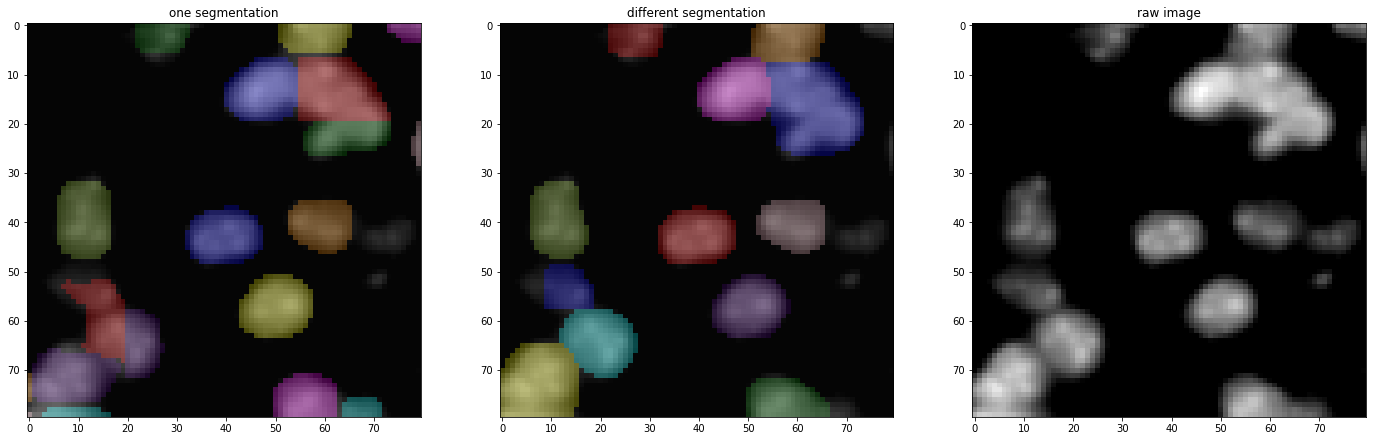

In [6]:
figure, axes = plt.subplots(ncols=3, figsize=(24, 24))

axes[0].imshow(skimage.color.label2rgb(label0[:80,:80], img[:80,:80], alpha=0.25, bg_label=0))
axes[1].imshow(skimage.color.label2rgb(label1[:80,:80], img[:80,:80], alpha=0.25, bg_label=0))
axes[2].imshow(img[:80,:80], cmap='gray')
axes[0].set_title("one segmentation")
axes[1].set_title("different segmentation")
axes[2].set_title("raw image")

### Here I do the geraph cutting, i.e. consensus segmentation

In [450]:
class ConsensusSegmentation():
    """ Takes many integer segmentation masks and produce a consensus segmentation mask.
        It does so by producing a graph in which each node is a foreground pixel and each edge
        is the number of times two pixel are segmented in the same object. 
        
        Typical usage:
        consensus = ConsensusSegmentation(integer_segmentation_masks)
        mask = consensus.mask()
    """
    
    def __init__(self, integer_masks):
        super().__init__()
        
        # size = ch, w, h. Contains the labels bg=0, fg= 1,2,...
        assert len(integer_masks.shape) == 3 
        
        self.integer_mask = integer_masks
        self.device = self.integer_mask.device
        self.ch, self.nx, self.ny = self.integer_mask.shape
        self.fg_mask = (torch.sum(self.integer_mask, dim=-3) > 0)
        
        ix_matrix, iy_matrix = torch.meshgrid([torch.arange(self.nx, dtype=int, device=self.device), 
                                               torch.arange(self.ny, dtype=int, device=self.device)])
        self.x_coordinate_fg_pixel = ix_matrix[self.fg_mask]
        self.y_coordinate_fg_pixel = iy_matrix[self.fg_mask]
        self.n_fg_pixel = self.x_coordinate_fg_pixel.shape[0]
        self.index_array = torch.arange(self.n_fg_pixel, dtype=int, device=self.device)
        self.index_matrix = -1*torch.ones_like(ix_matrix)
        self.index_matrix[self.x_coordinate_fg_pixel, 
                          self.y_coordinate_fg_pixel] = self.index_array
        
        partition_tmp = self.integer_mask[0,
                                          self.x_coordinate_fg_pixel, 
                                          self.y_coordinate_fg_pixel]
        self.initial_partition = dict(zip(self.index_array.numpy(),partition_tmp.numpy()))
        
        
        print("n_fg_pixel -->",self.n_fg_pixel)
        
    @functools.lru_cache(maxsize=10)  
    def mask_NN(self, radius=2, resolution=1):
        return self.compute_mask(resolution=resolution, radius=radius, dense=False)
    
    @functools.lru_cache(maxsize=10)  
    def mask_DENSE(self, resolution=1):
        return self.compute_mask(resolution=resolution, radius=0, dense=True)
    
    @functools.lru_cache(maxsize=10) 
    def similarity_NN(self, radius=2):
        return self.compute_similarity_NN(radius)
    
    @functools.lru_cache(maxsize=10) 
    def similarity_DENSE(self):
        return self.compute_similarity_DENSE()
    
    def compute_similarity_DENSE(self):
        """ Build the graph in which each pixel is connected to all other pixel belonging to same instance """
        print("Setting value S_DENSE")
        
        result = None
        for ch in range(self.ch):
            n_max = torch.max(self.integer_mask[ch].flatten()).item()
            for n in range(1,n_max+1):
                indeces = self.index_matrix[self.integer_mask[ch]==n]
                if indeces.shape[0] > 0:
                    
                    i = indeces.view(-1,1).repeat(indeces.shape[0],1).view(-1) # a,b,c,a,b,c,a,b,c
                    j = indeces.view(-1,1).repeat(1,indeces.shape[0]).view(-1) # a,a,a,b,b,b,c,c,c
                    v = torch.ones_like(i) # * (i != j)  # keep self edge
                    M = coo_matrix((v.numpy(), (i.numpy(), j.numpy())), 
                                   dtype='int', 
                                   shape=(self.n_fg_pixel,self.n_fg_pixel))
                    result = M if result is None else result + M     
        return result
    
    
    def compute_similarity_NN(self, radius):
        """ Build the Nearest Neightbor graph with radius d_max """
        print("Setting value SNN")
        
        result = None
        for dx in range(-radius,radius+1):
            index_tmp = torch.roll(self.index_matrix, dx, dims=-2)
            mask_tmp = torch.roll(self.integer_mask, dx, dims=-2)
            for dy in range(-radius,radius+1):
                index_shifted = torch.roll(index_tmp, dy, dims=-1)
                mask_shifted = torch.roll(mask_tmp, dy, dims=-1)
                #if(dx==0 and dy==0):
                #    continue
                
                check = (self.integer_mask == mask_shifted) * (self.integer_mask > 0)
                edge = torch.sum(check, dim=-3)
                
                i_tmp = self.index_matrix[edge>0]
                j_tmp = index_shifted[edge>0]
                v_tmp = edge[edge>0]
                
                M = coo_matrix((v_tmp.numpy(), (i_tmp.numpy(), j_tmp.numpy())), 
                                 dtype='int', shape=(self.n_fg_pixel,self.n_fg_pixel))
                
                result = M if result is None else result + M  
                    
        return result

    def compute_mask(self, resolution: float, radius: int, dense: bool):
        """ Perform Louvaine algorithm at a given resolution """

        if dense:
            graph = nx.from_scipy_sparse_matrix(self.similarity_DENSE())
        else:
            graph = nx.from_scipy_sparse_matrix(self.similarity_NN(radius))

        print("--- Starting Louvain Algorithm ---")
        start_time = time.time()
        partition = community_louvain.best_partition(graph, 
                                                     partition=None, #self.initial_partition,
                                                     resolution=resolution, 
                                                     randomize=True)
        print("--- Louvain Algorithm time -> %s seconds ---" % (time.time() - start_time))
                    
        assert (torch.tensor(list(partition.keys())) == self.index_array).all()
        instace_IDs = torch.tensor(list(partition.values())) + 1  # +1 b/c label_bg=0, label_fg=1,2,...
                
        # Write data using left indexing (very fast)
        consensus_mask = torch.zeros_like(self.index_matrix)
        consensus_mask[self.x_coordinate_fg_pixel, self.y_coordinate_fg_pixel] = instace_IDs
        
        return consensus_mask

In [451]:

consensus = ConsensusSegmentation(integer_seg_mask[:,:80,:80])
#consensus = ConsensusSegmentation(integer_seg_mask)

n_fg_pixel --> 2103


Text(0.5, 1.0, 'raw img')

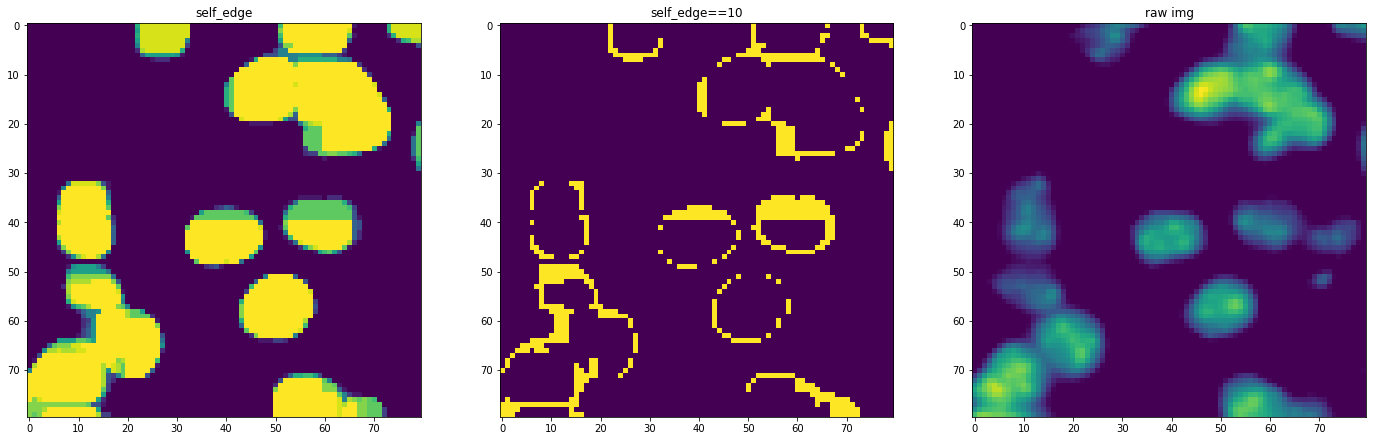

In [452]:
#plt.imshow(consensus.index_matrix)
self_edge = torch.sum(consensus.integer_mask > 0,dim=-3)

figure, axes = plt.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(self_edge)
axes[1].imshow((self_edge>0) * (self_edge<15))
axes[2].imshow(img[:80,:80])
axes[0].set_title("self_edge")
axes[1].set_title("self_edge==10")
axes[2].set_title("raw img")

In [453]:
consensus.similarity_DENSE()

Setting value S_DENSE


<2103x2103 sparse matrix of type '<class 'numpy.longlong'>'
	with 440197 stored elements in Compressed Sparse Row format>

In [454]:
consensus.similarity_NN()

Setting value SNN


<2103x2103 sparse matrix of type '<class 'numpy.longlong'>'
	with 44487 stored elements in Compressed Sparse Row format>

In [455]:
consensus.similarity_NN().toarray()[:15,:15]

array([[10, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10, 15, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10, 15, 15, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 15, 15, 15, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 15, 15, 15, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 15, 15, 15, 15, 15,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 15, 15, 15, 15, 15,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 15, 15, 15, 15, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 15, 15, 15, 15,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 15, 15, 15,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 11, 11,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 16, 16, 16],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 16, 16, 16],
       [ 0,  0,  0,  0,  0,  0,  0

In [456]:
consensus.similarity_DENSE().toarray()[:15,:15]

array([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  0,  0,  0,  0],
       [10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 16, 16, 16],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 16, 16, 16],
       [ 0,  0,  0,  0,  0,  0,  0

Setting value SNN
--- Starting Louvain Algorithm ---
--- Louvain Algorithm time -> 3.455436944961548 seconds ---
--- Starting Louvain Algorithm ---
--- Louvain Algorithm time -> 10.40682578086853 seconds ---


Text(0.5, 1.0, 'raw img')

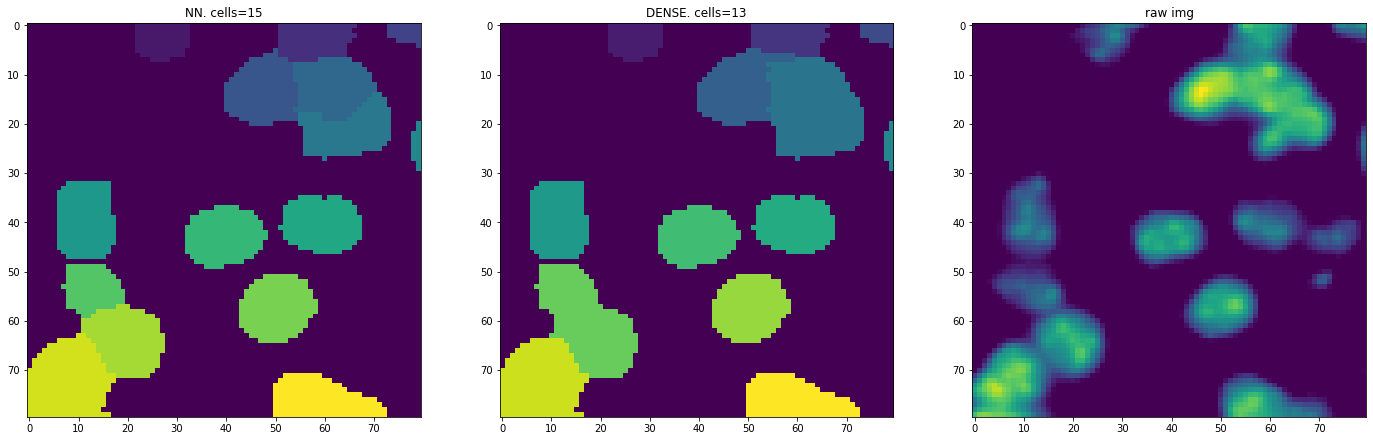

In [457]:
label0 = consensus.mask_NN(resolution=1.0).numpy()
label1 = consensus.mask_DENSE(resolution=1.0).numpy()

n0 = np.max(label0).item()
n1 = np.max(label1).item()

figure, axes = plt.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(label0)
axes[1].imshow(label1)
axes[2].imshow(img[:80,:80])
axes[0].set_title("NN. cells="+str(n0))
axes[1].set_title("DENSE. cells="+str(n1))
axes[2].set_title("raw img")

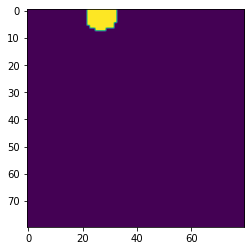

In [422]:
plt.imshow(label0==1)
#assert 1==2
# change Louvaine to Leden
# all to all favours the large comunity
# add self interaction?

[0 0 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0]


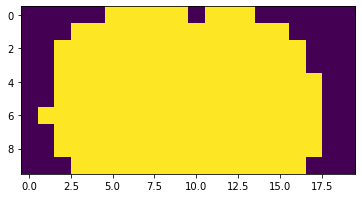

In [432]:
plt.imshow(label0[35:45,50:70])
print(label0[40,50:70])

##### RESULT 1: resolution=1

In [193]:
label0 = consensus.integer_mask[0].numpy()
label1 = consensus.integer_mask[-1].numpy()
label2 = mask_1.numpy()

430 380 239


Text(0.5, 1.0, 'raw image')

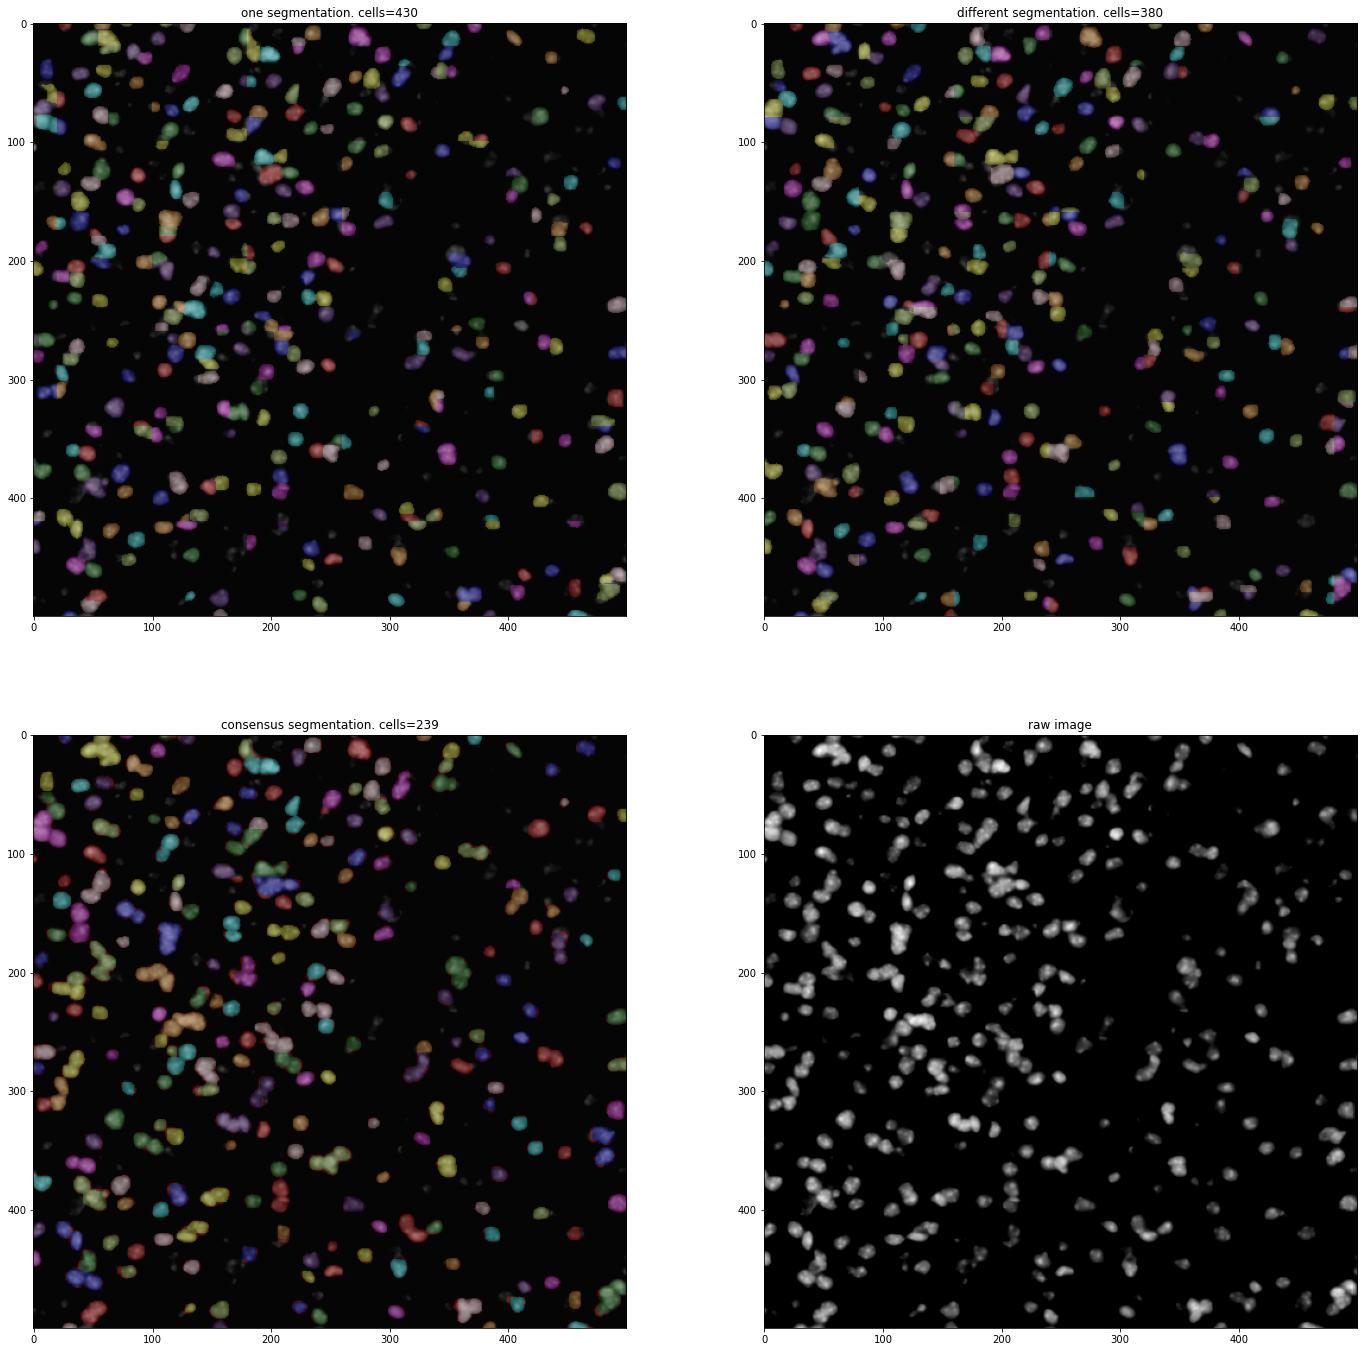

In [194]:
n0 = np.max(label0).item()
n1 = np.max(label1).item()
n2 = np.max(label2).item()
print(n0,n1,n2)

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 24))
axes[0,0].imshow(skimage.color.label2rgb(label0 % 255, img, alpha=0.25, bg_label=0))
axes[0,1].imshow(skimage.color.label2rgb(label1 % 255, img, alpha=0.25, bg_label=0))
axes[1,0].imshow(skimage.color.label2rgb(label2 % 255, img, alpha=0.25, bg_label=0))
axes[1,1].imshow(img, cmap='gray')
axes[0,0].set_title("one segmentation. cells="+str(n0))
axes[0,1].set_title("different segmentation. cells="+str(n1))
axes[1,0].set_title("consensus segmentation. cells="+str(n2))
axes[1,1].set_title("raw image")

### ZOOMED RESULT 1: resolution=1

109 156


Text(0.5, 1.0, 'raw image')

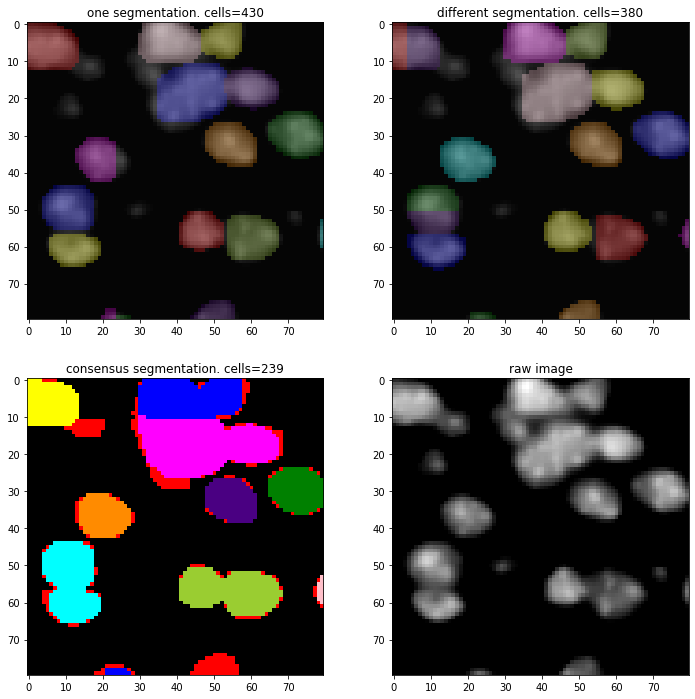

In [202]:
dx, dy = 80, 80
ix = np.random.randint(low=0, high=img.shape[-2]-dx, size=[1]).item()
iy = np.random.randint(low=0, high=img.shape[-1]-dy, size=[1]).item()
print(ix,iy)

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
axes[0,0].imshow(skimage.color.label2rgb(label0[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=0.25, bg_label=0))
axes[0,1].imshow(skimage.color.label2rgb(label1[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=0.25, bg_label=0))
axes[1,0].imshow(skimage.color.label2rgb(label2[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=1.0, bg_label=0))
axes[1,1].imshow(img[ix:(ix+dx),iy:(iy+dy)], cmap='gray')
axes[0,0].set_title("one segmentation. cells="+str(n0))
axes[0,1].set_title("different segmentation. cells="+str(n1))
axes[1,0].set_title("consensus segmentation. cells="+str(n2))
axes[1,1].set_title("raw image")

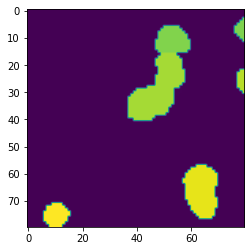

In [200]:
a = label2[252:(252+80),276:(276+80)]
plt.imshow(a)


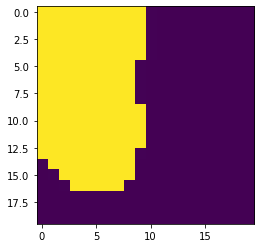

In [201]:
b = a[60:80,60:80]
plt.imshow(b)

### RESULT 2: resolution=0.1

In [204]:
label0 = consensus.integer_mask[0].numpy()
label1 = consensus.integer_mask[-1].numpy()
label2 = mask_01.numpy()

430 380 304


Text(0.5, 1.0, 'raw image')

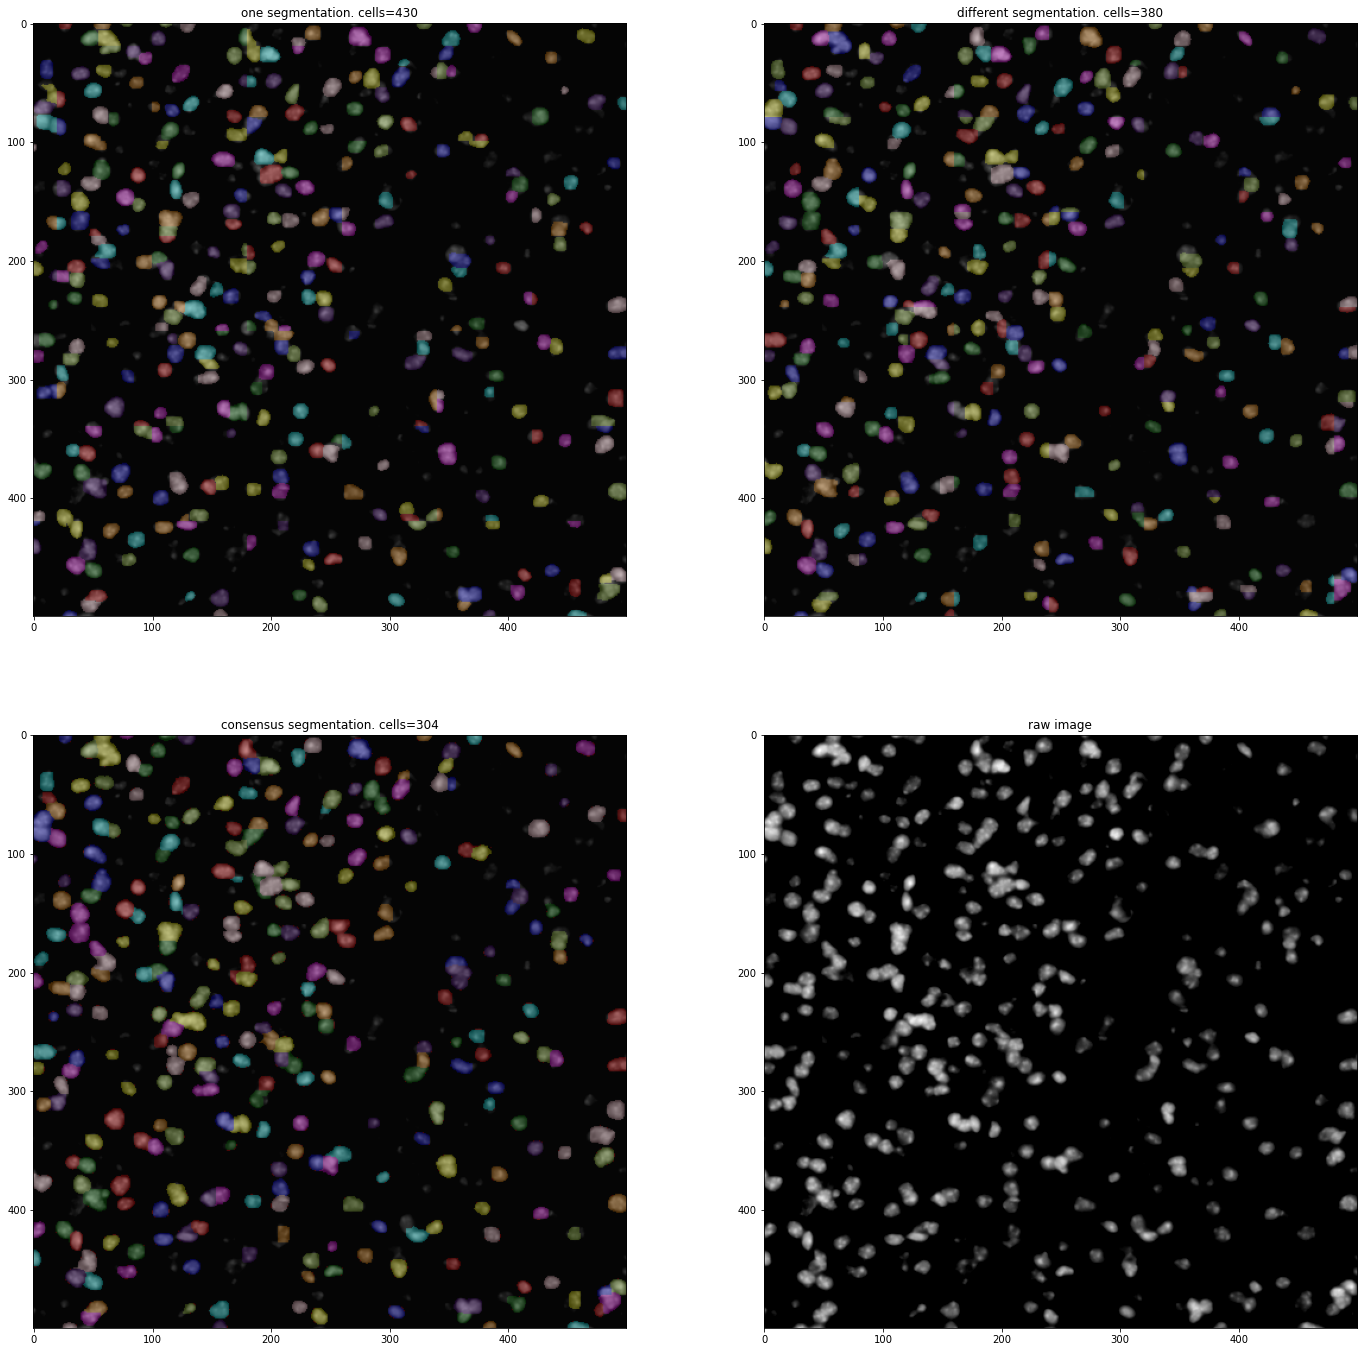

In [205]:
n0 = np.max(label0).item()
n1 = np.max(label1).item()
n2 = np.max(label2).item()
print(n0,n1,n2)

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 24))
axes[0,0].imshow(skimage.color.label2rgb(label0 % 255, img, alpha=0.25, bg_label=0))
axes[0,1].imshow(skimage.color.label2rgb(label1 % 255, img, alpha=0.25, bg_label=0))
axes[1,0].imshow(skimage.color.label2rgb(label2 % 255, img, alpha=0.25, bg_label=0))
axes[1,1].imshow(img, cmap='gray')
axes[0,0].set_title("one segmentation. cells="+str(n0))
axes[0,1].set_title("different segmentation. cells="+str(n1))
axes[1,0].set_title("consensus segmentation. cells="+str(n2))
axes[1,1].set_title("raw image")

### ZOOMED RESULT 2: resolution=0.1

Text(0.5, 1.0, 'raw image')

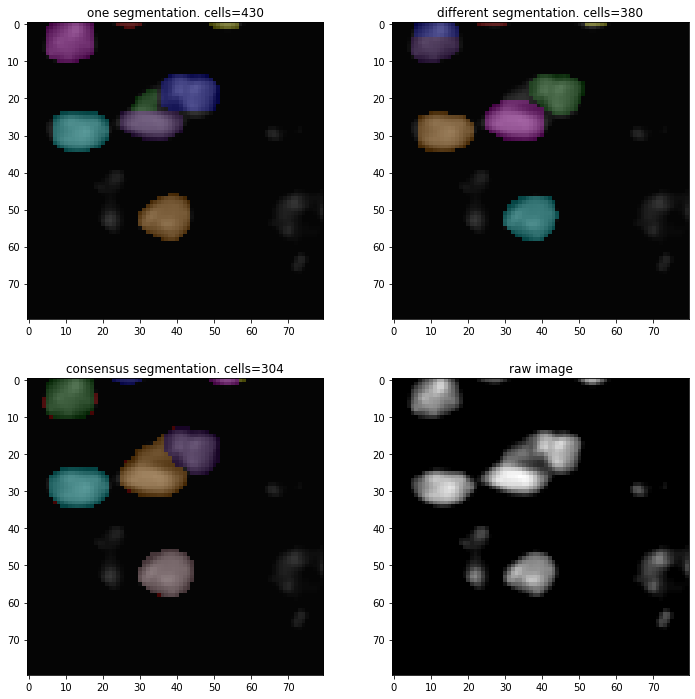

In [206]:
dx, dy = 80, 80
ix = np.random.randint(low=0, high=img.shape[-2]-dx, size=[1]).item()
iy = np.random.randint(low=0, high=img.shape[-1]-dy, size=[1]).item()

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
axes[0,0].imshow(skimage.color.label2rgb(label0[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=0.25, bg_label=0))
axes[0,1].imshow(skimage.color.label2rgb(label1[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=0.25, bg_label=0))
axes[1,0].imshow(skimage.color.label2rgb(label2[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=0.25, bg_label=0))
axes[1,1].imshow(img[ix:(ix+dx),iy:(iy+dy)], cmap='gray')
axes[0,0].set_title("one segmentation. cells="+str(n0))
axes[0,1].set_title("different segmentation. cells="+str(n1))
axes[1,0].set_title("consensus segmentation. cells="+str(n2))
axes[1,1].set_title("raw image")